# ACCESS-OM2-01 Surface Water Mass Transformation

In [26]:
import intake
import cosima_cookbook as cc
import glob

import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed as dsk
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [30]:
import time

In [28]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)

### Computing surface water mass transformation
We will do this by defining three functions. The first one loads the diagnostics needed (independently of the model). The second one actually calculates the transformations, and a third one does the density binning.

In [3]:
def get_variables_0(expt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time,
                                                end_time = end_time,
                                                chunks = {'time': 1})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time, end_time))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

For perturbation full years

In [4]:
def get_variables_1(expt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time_broad,
                                                end_time = end_time_broad,
                                                chunks = {'time': 1})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time_real, end_time_real))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

Defining new get_variables function to be used for jan-oct period.

In [5]:
def get_variables_2(expt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time_broad,
                                                end_time = end_time_broad,
                                                chunks = {'time': 1})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time_real, end_time_real))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1

    ## BELOW HAS BEEN CHANGED TO JUST BE JAN-OCT
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

Defining the salt and heat transformations

In [6]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_net by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation


Now we need to do the isopycnal re-binning

In [7]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) 
    bin_bottoms = isopycnal_bins[:-1]    
    pot_rho_1 = ds['pot_rho_1']
    X = pot_rho_1.cf['longitude']
    Y = pot_rho_1.cf['latitude']
    
    binned_salt_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'salt_transformation')

    binned_heat_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'temp_transformation')
    
    binned_salt_transformation = binned_salt_transformation.chunk({'isopycnal_bins': 1})
    binned_heat_transformation = binned_heat_transformation.chunk({'isopycnal_bins': 1})
    
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform

        masked_transform = (heat_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform

    ndays = ds['days_per_month'].sum().values
    salt_transformation = binned_salt_transformation / ndays
    
    c_p = 3992.1 # J kg-1 degC-1
    heat_transformation = binned_heat_transformation / c_p / ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1]) / 2
    salt_transformation['isopycnal_bins'] = isopycnal_bin_mid
    heat_transformation['isopycnal_bins'] = isopycnal_bin_mid
    
    # Change the sign so that positive means conversion into denser water masses
    salt_transformation = -1 * salt_transformation
    heat_transformation = -1 * heat_transformation

    return salt_transformation, heat_transformation

## Saving per year via manual method

In [8]:
# Change to your experiment of interest
expt_con = '01deg_jra55v13_ryf9091_21mbath'
expt_melt = '01deg_jra55v13_ryf9091_21mbath_sofia_ssp126'
db = '/home/272/kc5856/databases/honours_test.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

#### First doing the control

In [9]:
# Painfully manual don't mind this

start_time = '1910-01-01'
end_time = '1910-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_01F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_01F.nc')

In [10]:
# Painfully manual don't mind this 2

start_time = '1911-01-01'
end_time = '1911-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_02F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_02F.nc')

In [11]:
# Painfully manual don't mind this 3

start_time = '1912-01-01'
end_time = '1912-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_03F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_03F.nc')

In [ ]:
# Painfully manual don't mind this 4

start_time = '1913-01-01'
end_time = '1913-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_04F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_04F.nc')

In [18]:
# Painfully manual don't mind this 5

start_time = '1914-01-01'
end_time = '1914-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_05F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_05F.nc')

In [19]:
# Painfully manual don't mind this 6
start_time = '1915-01-01'
end_time = '1915-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_06F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_06F.nc')

In [31]:
%%time

# Painfully manual don't mind this 7.1
start_time = '1916-01-01'
end_time = '1916-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           

CPU times: user 24 s, sys: 4.59 s, total: 28.6 s
Wall time: 1min 4s


In [32]:
%%time

# Painfully manual don't mind this 7.2           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

CPU times: user 26.4 s, sys: 2.18 s, total: 28.6 s
Wall time: 28.7 s


In [ ]:
%%time

# Painfully manual don't mind this 7.3           
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)


In [ ]:
%%time

# Painfully manual don't mind this 7.4           

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_07F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_07F.nc')

In [ ]:
# Painfully manual don't mind this 8
start_time = '1917-01-01'
end_time = '1917-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_08F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_08F.nc')

In [ ]:
# Painfully manual don't mind this 9
start_time = '1918-01-01'
end_time = '1918-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_09F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_09F.nc')

In [ ]:
# Painfully manual don't mind this 10
start_time = '1919-01-01'
end_time = '1919-12-31'

ds = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_10F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_10F.nc')

2025-05-28 16:29:30,468 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/asyncio/base_events.py", line 650, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/asyncio/locks.py", l

Doing the same for the perturbation experiment:

In [10]:
# Painfully manual don't mind this
start_time_broad = '1910-01-01'
start_time_real = '1910-01-01'
end_time_broad = '1911-04-01'
end_time_real = '1910-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_01F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_01F.nc')

In [7]:
# Painfully manual don't mind this 2

start_time_real = '1911-01-01'
end_time_broad = '1912-04-01'
end_time_real = '1911-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_02F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_02F.nc')

In [ ]:
# Painfully manual don't mind this 3

start_time_real = '1912-01-01'
end_time_broad = '1913-04-01'
end_time_real = '1912-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_03F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_03F.nc')

In [7]:
# Painfully manual don't mind this 4

start_time_real = '1913-01-01'
end_time_broad = '1914-04-01'
end_time_real = '1913-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_04F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_04F.nc')

2025-05-26 13:28:22,140 - tornado.application - ERROR - Exception in callback <bound method Worker.trigger_profile of <Worker 'tcp://127.0.0.1:39351', name: 27, status: running, stored: 0, running: 1/1, ready: 0, comm: 0, waiting: 0>>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/profile.py", line 66, in identifier
    co.co_name,
    ^^^^^^^^^^
AttributeError: 'str' object has no attribute 'co_name'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 2448, in trigger_profile
    state = profile.process(
            ^^^^^^^^^^^^^^^^
  File "/

In [7]:
# Painfully manual don't mind this 5

start_time_real = '1914-01-01'
end_time_broad = '1915-04-01'
end_time_real = '1914-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_05F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_05F.nc')

In [8]:
# Painfully manual don't mind this 6

start_time_real = '1915-01-01'
end_time_broad = '1916-04-01'
end_time_real = '1915-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')

salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_06F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_06F.nc')

2025-05-26 17:09:20,407 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:37047 -> tcp://127.0.0.1:37711
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [9]:
# Painfully manual don't mind this 7

start_time_real = '1916-01-01'
end_time_broad = '1917-04-01'
end_time_real = '1916-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_07F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_07F.nc')

In [ ]:
# Painfully manual don't mind this 8

start_time_real = '1917-01-01'
end_time_broad = '1918-04-01'
end_time_real = '1917-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_08F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_08F.nc')

In [ ]:
# Painfully manual don't mind this 9

start_time_real = '1918-01-01'
end_time_broad = '1919-04-01'
end_time_real = '1918-12-31'

ds = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_09F.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_09F.nc')

In [12]:
# Painfully manual don't mind this 10
# Note - this is different to above cells to accommodate shorter ending of melt data.

start_time_broad = '1918-06-01'
start_time_real = '1919-01-01'
end_time_broad = '1920-04-01'
end_time_real = '1919-10-16'

ds = get_variables_2(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')

salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)
                     
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_10F_short.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_10F_short.nc')

### Opening the saved data

Update once Pan01 method is working.

In [8]:
# Importing the saved files for control
salt_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_*'))
heat_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_*'))

In [9]:
salt_tr = xr.open_mfdataset(salt_files_C, concat_dim='time', combine='nested')
heat_tr = xr.open_mfdataset(heat_files_C, concat_dim='time', combine='nested')

In [10]:
salt_tr = salt_tr.to_array().squeeze()
heat_tr = heat_tr.to_array().squeeze()

In [11]:
# Importing the saved files for perturbation
salt_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_*'))
heat_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_*'))

In [12]:
salt_tr_melt = xr.open_mfdataset(salt_files_M, concat_dim='time', combine='nested')
heat_tr_melt = xr.open_mfdataset(heat_files_M, concat_dim='time', combine='nested')

In [13]:
salt_tr_melt = salt_tr_melt.to_array().squeeze()
heat_tr_melt = heat_tr_melt.to_array().squeeze()

In [14]:
net_tr = salt_tr + heat_tr
net_tr_melt = salt_tr_melt + heat_tr_melt

In [15]:
#Defining the data separately for variables like area, depth, etc.
expt_con = '01deg_jra55v13_ryf9091_21mbath'
expt_melt = '01deg_jra55v13_ryf9091_21mbath_sofia_ssp126'
db = '/home/272/kc5856/databases/honours_test.db'
session = cc.database.create_session(db)

lon_slice = slice(None, None)
lat_slice = slice(None, -59)
freq = '1 monthly'
start_time_broad = '1910-10-01'
end_time_broad = '1912-01-01'
start_time_real = '1911-01-01'
end_time_real = '1911-12-31' # only one year here because we are only needing it for area  

start_time = '1911-01-01'
end_time = '1911-12-31'

ds_cont = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
ds_melt = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')

### Antarctic shelf dense water formation

In [16]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [17]:
depth = xr.Dataset(ds_cont['maximum_depth']).to_array().squeeze()
depth_melt = xr.Dataset(ds_melt['maximum_depth']).to_array().squeeze()
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [18]:
area = xr.Dataset(ds_cont['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf = (net_tr * area / 1e6).where(shelf_mask == 1)
heat_shelf = (heat_tr * area / 1e6).where(shelf_mask == 1)
salt_shelf = (salt_tr * area / 1e6).where(shelf_mask == 1)
swmt_shelf_sum = swmt_shelf.cf.sum(['longitude', 'latitude'])
heat_shelf_sum = heat_shelf.cf.sum(['longitude', 'latitude'])
salt_shelf_sum = salt_shelf.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

In [19]:
area_melt = xr.Dataset(ds_melt['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf_melt = (net_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
heat_shelf_melt = (heat_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
salt_shelf_melt = (salt_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
swmt_shelf_melt_sum = swmt_shelf_melt.cf.sum(['longitude', 'latitude'])
heat_shelf_melt_sum = heat_shelf_melt.cf.sum(['longitude', 'latitude'])
salt_shelf_melt_sum = salt_shelf_melt.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_melt_sum, heat_shelf_melt_sum, salt_shelf_melt_sum]:
    da.attrs["units"] = "Sv"

In [20]:
transformation_density = 32.6
shelf_subduction_plot = net_tr.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = depth.cf['X']
swmt_yt = depth.cf['Y']

In [21]:
transformation_density = 32.6
shelf_subduction_plot_melt = net_tr_melt.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_melt = depth_melt.cf['X']
swmt_yt_melt = depth_melt.cf['Y']

In [22]:
anom_xt = swmt_xt_melt - swmt_xt
anom_yt = swmt_yt_melt - swmt_yt

In [23]:
shelf_subduction_plot_anom = shelf_subduction_plot_melt - shelf_subduction_plot

In [24]:
import matplotlib.path as mpath

In [25]:
# Taking time means
shelf_subduction_plot_anom_ave = shelf_subduction_plot_anom.mean(dim='time')

swmt_shelf_melt_sum_ave = swmt_shelf_melt_sum.mean(dim='time')
heat_shelf_melt_sum_ave = heat_shelf_melt_sum.mean(dim='time')
salt_shelf_melt_sum_ave = salt_shelf_melt_sum.mean(dim='time')

swmt_shelf_sum_ave = swmt_shelf_sum.mean(dim='time')
heat_shelf_sum_ave = heat_shelf_sum.mean(dim='time')
salt_shelf_sum_ave = salt_shelf_sum.mean(dim='time')

In [26]:
#Cell defining 25% and 75% markers. ## TO UPDATE
#cont_d25 = 32.69
#cont_d75 = 32.55

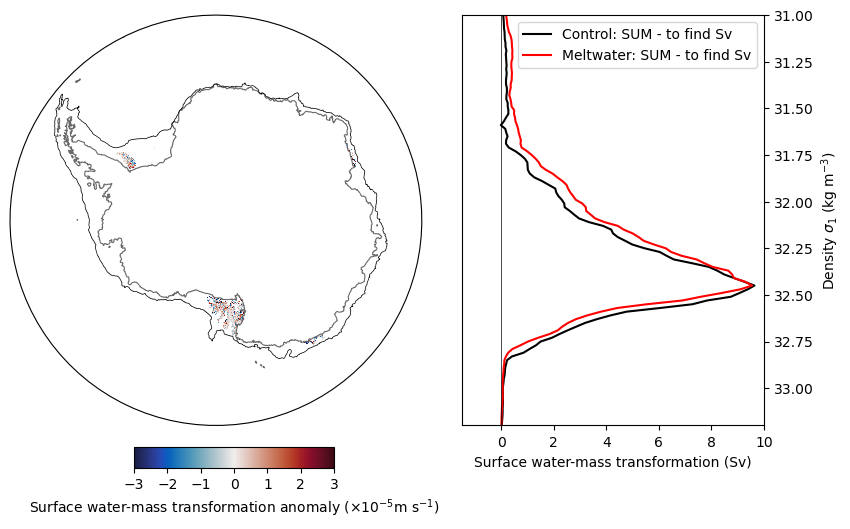

In [33]:
fig = plt.figure(1, figsize = (10, 5.33))
gs = gridspec.GridSpec(1, 2, width_ratios = [3, 2], wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection = ccrs.SouthPolarStereo()), plt.subplot(gs[1])
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey', linewidths=0.75, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5, transform = ccrs.PlateCarree())

norm = mcolors.Normalize(vmin = -2.5, vmax = 2.5)
plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot_anom_ave,
                          vmin = -3, vmax = 3,
                          cmap = cm.cm.balance,
                          transform = ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [-3,-2,-1,0, 1, 2, 3])
cbar.set_label(r'Surface water-mass transformation anomaly ($\times 10^{-5}$m s$^{-1}$)')

ax1.plot(swmt_shelf_sum_ave, swmt_shelf_sum_ave['isopycnal_bins'], color = 'k', label='Control: SUM - to find Sv')
ax1.plot(swmt_shelf_melt_sum_ave, swmt_shelf_melt_sum_ave['isopycnal_bins'], color = 'r', label='Meltwater: SUM - to find Sv')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
#ax1.plot([-5, 15], [cont_d25, cont_d25], 'k--', linewidth=1)
#ax1.plot([-5, 15], [cont_d75, cont_d75], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel('Density $\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();

### Finding the 25% and 75%

Control max = BLANK Sv (at density ).  
- 25% of max (BLANK Sv) = BLANK
- 75% of max (BLANK Sv) = BLANK
- Control total transport in this slice = BLANK Sv
      
Melt max = BLANK Sv (at density BLANK).  
- 25% of max (BLANK Sv) = BLANK
- 75% of max (BLANK Sv) = BLANK
- Melt total transport in this slice = BLANK Sv.

We just use the control lines as our formation region. 

Finding the sums: (change density values below to match 25 and 75 thresholds)

In [44]:
print(swmt_shelf_sum_ave.max('isopycnal_bins'))

<xarray.DataArray ()> Size: 8B
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    variable  <U2 8B 'ht'


In [ ]:
swmt_shelf_melt_sum_ave.max().compute()

In [35]:
swmt_shelf_sum_ave.sel(isopycnal_bins=32.4, method='nearest').compute()

<xarray.DataArray ()> Size: 8B
array(8.86244887)
Coordinates:
    isopycnal_bins  float64 8B 32.41
    variable        <U2 8B 'ht'

In [91]:
swmt_shelf_sum_ave.sel(isopycnal_bins=slice(32.51,32.65)).compute().sum()

<xarray.DataArray ()> Size: 8B
array(2.23448954)
Coordinates:
    isopycnal_bins  float64 8B 32.71
    variable        <U2 8B 'ht'
Attributes:
    units:    Sv

In [ ]:
swmt_shelf_melt_sum_ave.sel(isopycnal_bins=slice(32.51,32.65)).compute().sum()